In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

housing = pd.read_csv("./data/housing.csv")
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing_num = housing.drop("ocean_proximity", axis=1)
housing_cat = housing[["ocean_proximity"]]

imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()





array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self # nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]





In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('attribs_adder', CombinedAttributesAdder()),
 ('std_scaler', StandardScaler()),
 ])
housing_num_tr = num_pipeline.fit_transform(housing_num)



In [4]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])

housing_prepared = full_pipeline.fit_transform(housing)

Select and Train a Model

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)   # X, y

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [6]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [7]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
print(housing_predictions[:5])
print(list(housing_labels[:5]))
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

[ 72100. 279600.  82700. 112500. 238300.]
[72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


0.0

In [8]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [69244.21939459 71920.56585833 69379.93495893 72153.3120617
 72343.48272116]
Mean: 71008.30299894106
Standard deviation: 1392.0881872861244


In [9]:


lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [68076.63768302 67881.16711321 69712.97514343 71266.9225777
 68390.25096271]
Mean: 69065.59069601327
Standard deviation: 1272.9445955637493


In [10]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores: [50269.26059953 49965.51388371 50104.11314374 51745.68701104
 51666.5302165 ]
Mean: 50750.22097090574
Standard deviation: 786.7806157347837


From these three scores, from Linear Regression, Decision Tree, to Random Forest, we choose Random Forest because it is the most accurate (lowest value).

Fine-Tune Your Model

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = [
 {'n_estimators': [100, 200, 500], 'max_features': [8]}
 ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_


{'max_features': 8, 'n_estimators': 500}

Now we use GridSearchCV to find the most impactful hyperparameters. 
```Chapter 2 Sheet has everything to know``` 

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

Conceptual Questions:

``` What is hyperparameter
What is GridSearch
What is Correlation Coefficent
What is overfitting
 etc```

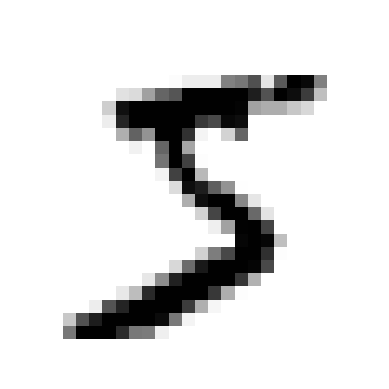

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt

df = pd.read_csv("./data/mnist.csv")
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
